In [1]:
using PyCall, PyPlot
using MARGO
inset_locator = pyimport("mpl_toolkits.axes_grid.inset_locator");
mpl = pyimport("matplotlib");
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams");

┌ Info: Precompiling MARGO [39978bfe-ac6a-4fbe-9981-75100ee30276]
└ @ Base loading.jl:1273


### Replicating Belaia (2019) configuration

In [2]:
ensemble = Dict();

Dict{Any,Any} with 0 entries

In [7]:
dt = 1. # year timestep
present_year = MARGO.present_year
t = Array(present_year:dt:2500);

# Increase discount rate
utility_discount_rate = 0.015 # ρ

# Modify control technology costs
mitigate_cost = (200. * 70.e9 / 1.e12) / MARGO.GWP(t)[t.==2100][1] # Costs from Figure 1 https://arxiv.org/abs/1903.02043
geoeng_cost = MARGO.β * (7.5^2); # Cost of offsetting all GHG warming is same as damages due to that warming 

# Modify baseline emissions scenario (Figure 4 https://arxiv.org/abs/1903.02043)
function baseline_emissions_Belaia()
    q = zeros(size(t))
    q[t.<=2120.] = (
        MARGO.GtCO2_to_ppm(75.) .- MARGO.GtCO2_to_ppm(40.) * ( (t[t.<=2120.] .- 2120.) ./ 100.).^2
    )
    q[t.>2120.] = (
        MARGO.GtCO2_to_ppm(75.) .- MARGO.GtCO2_to_ppm(30.) * ( (t[t.>2120.] .- 2120.) ./ 130.).^2.
    )
    q[q .< 0] .= 0.
    return q
end
baseline_emissions_scenario = baseline_emissions_Belaia()

# Modify economic submodule with updated new costs and baseline emissions
economics = Economics(
    MARGO.GWP(t), MARGO.β, utility_discount_rate,
    mitigate_cost, 0., geoeng_cost, 0.,
    0.03, 0., 0., nothing, # Assumed initial condition of zero control deployments in 2020
    baseline_emissions_scenario
);

# Modify physical parameters
a = 5.35 # Increase proportionality constant of empirical CO2 forcing
physics = Physics(
    MARGO.CO₂_init, MARGO.δT_init, MARGO.a, MARGO.B*0.8,
    MARGO.Cd*0.75, MARGO.κ*0.75, MARGO.r
)
physics.r = 0.75 # Increase fraction of baseline emissions that stay in the atmosphere

# Arbitrary initial guess of climate control policies, to be optimized later!
controls = MARGO.init_zero_controls(t);

# Create instance of idealized integrated assessment climate model
mname = "Belaia"
model = ClimateModel(mname, t, dt, 2020., economics, physics, MARGO.deepcopy(controls));

# Modify optimization parameters (no adaptation, no explicit removal, no limit on how early deployment can be)
start_deployment=Dict("remove"=>2020., "mitigate"=>2020., "geoeng"=>2020., "adapt"=>2020.)
cost_exponent = Dict("mitigate" => 2.8, "geoeng" => 2., "adapt" => 0., "remove" => 0.)

# Much higher intertia in deployment rates
slope = 1. /90
max_slope = Dict("mitigate" => slope, "geoeng" => slope, "adapt" => slope, "remove" => slope);

In [8]:
optimize_controls!(
    model,
    obj_option = "net_benefit",
    max_deployment=Dict("remove"=>0., "mitigate"=>1., "geoeng"=>0., "adapt"=>0.),
    start_deployment=start_deployment,
    max_slope = max_slope,
    cost_exponent=cost_exponent
);

ensemble["M"] = deep_copy(model);

Solve_Succeeded


### Plotting the optimal solution state

In [9]:
model = ClimateModel(mname, t, dt, present_year, economics, physics, MARGO.deepcopy(controls),);
optimize_controls!(
    model,
    obj_option = "net_benefit",
    max_deployment=Dict("remove"=>0., "mitigate"=>2., "geoeng"=>0., "adapt"=>0.),
    start_deployment=start_deployment,
    max_slope = max_slope,
    cost_exponent=cost_exponent
);
ensemble["MR"] = deep_copy(model);

model = ClimateModel(mname, t, dt, present_year, economics, physics, MARGO.deepcopy(controls),);
optimize_controls!(
    model,
    obj_option = "net_benefit",
    max_deployment=Dict("remove"=>0., "mitigate"=>2., "geoeng"=>1., "adapt"=>0.),
    start_deployment=start_deployment,
    max_slope = max_slope,
    cost_exponent=cost_exponent
);
ensemble["MRG"] = deep_copy(model);

Solve_Succeeded
Solve_Succeeded


#### Replicate Figure 4

In [10]:
ensemble

Dict{Any,Any} with 3 entries:
  "MRG" => ClimateModel("Belaia", [2020.0, 2021.0, 2022.0, 2023.0, 2024.0, 2025…
  "MR"  => ClimateModel("Belaia", [2020.0, 2021.0, 2022.0, 2023.0, 2024.0, 2025…
  "M"   => ClimateModel("Belaia", [2020.0, 2021.0, 2022.0, 2023.0, 2024.0, 2025…

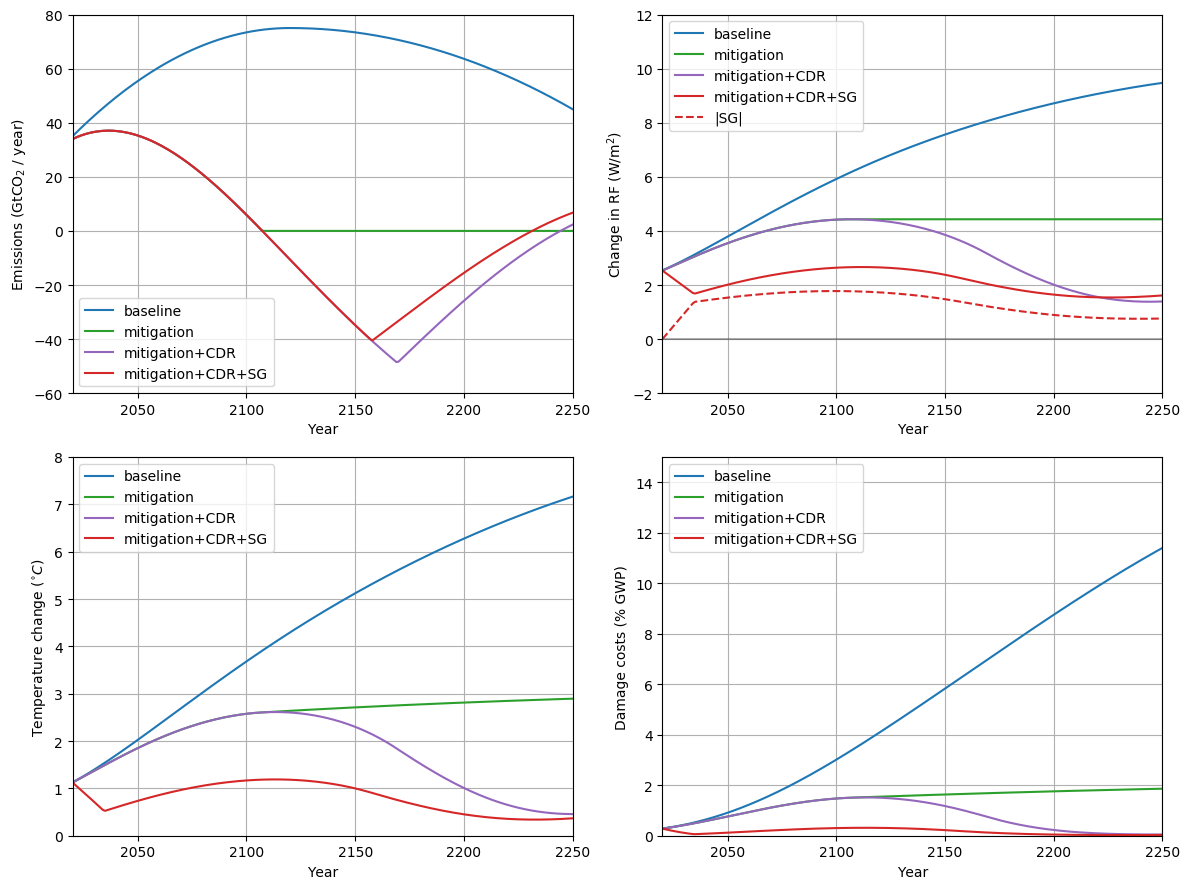

In [13]:
rcParams["lines.linestyle"] = "-"

figure(figsize=(12,9))
subplot(2,2,1)
plot(model.domain, MARGO.ppm_to_GtCO2(model.economics.baseline_emissions), "C0", label="baseline")
plot(model.domain, MARGO.ppm_to_GtCO2(MARGO.controlled_emissions(ensemble["M"])), "C2", label="mitigation")
plot(model.domain, MARGO.ppm_to_GtCO2(MARGO.controlled_emissions(ensemble["MR"])), "C4", label="mitigation+CDR")
plot(model.domain, MARGO.ppm_to_GtCO2(MARGO.controlled_emissions(ensemble["MRG"])), "C3", label="mitigation+CDR+SG")
legend(loc = "lower left")
ylim([-60,80])
xlim([2020., 2250.])
xlabel("Year")
ylabel(L"Emissions (GtCO$_{2}$ / year)")
grid(true)

subplot(2,2,2)
F0 = 2.5
plot(model.domain, 0. * model.domain, "k-", alpha=0.3, lw=1.5)
plot(model.domain, MARGO.FCO₂_baseline(model)/MARGO.sec_per_year .+ F0, "C0", label="baseline")
plot(model.domain, MARGO.FCO₂(ensemble["M"])/MARGO.sec_per_year .+ F0, "C2", label="mitigation")
plot(model.domain, MARGO.FCO₂(ensemble["MR"])/MARGO.sec_per_year .+ F0, "C4", label="mitigation+CDR")
plot(model.domain, MARGO.FCO₂(ensemble["MRG"])/MARGO.sec_per_year .+ F0, "C3", label="mitigation+CDR+SG")
plot(model.domain, abs.(MARGO.FCO₂(ensemble["MRG"]) - MARGO.FCO₂_no_geoeng(ensemble["MRG"]))/MARGO.sec_per_year, "C3--", label="|SG|")
xlim([2020., 2250.])
ylim([-2,12])
xlabel("Year")
ylabel(L"Change in RF (W/m$^{2}$)")
legend()
grid(true)

subplot(2,2,3)
plot(model.domain, MARGO.δT_baseline(ensemble["M"]), "C0", label="baseline")
plot(model.domain, MARGO.δT(ensemble["M"]), "C2", label="mitigation")
plot(model.domain, MARGO.δT(ensemble["MR"]), "C4", label="mitigation+CDR")
plot(model.domain, MARGO.δT(ensemble["MRG"]), "C3", label="mitigation+CDR+SG")
xlabel("Year")
ylabel(L"Temperature change ($^{\circ}C$)")
ylim([0,8])
xlim([2020., 2250.])
legend()
grid(true)

subplot(2,2,4)
plot(model.domain, MARGO.damage_cost_baseline(ensemble["M"])./MARGO.GWP(t)*100., "C0", label="baseline")
plot(model.domain, MARGO.damage_cost(ensemble["M"])./MARGO.GWP(t)*100., "C2", label="mitigation")
plot(model.domain, MARGO.damage_cost(ensemble["MR"])./MARGO.GWP(t)*100., "C4", label="mitigation+CDR")
plot(model.domain, MARGO.damage_cost(ensemble["MRG"])./MARGO.GWP(t)*100., "C3", label="mitigation+CDR+SG")
xlabel("Year")
ylabel("Damage costs (% GWP)")
xlim([2020., 2250.])
ylim([0., 15.])
grid(true)
legend(loc="upper left")
tight_layout()

#savefig("../figures/replicate_Belaia_2019.pdf", dpi=150, bbox_inches="tight")